In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):
    
    nfeatures = 100
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4)
        + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, random_state=random_state)

## Train GAMI-Net 

In [3]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
                interact_arch=[40] * 5, subnet_arch=[40] * 5, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                mono_increasing_list=[], mono_decreasing_list=[1],
                verbose=True, val_ratio=0.2, random_state=random_state)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.02991, val loss: 0.02914
Main effects training epoch: 2, train loss: 0.01997, val loss: 0.02009
Main effects training epoch: 3, train loss: 0.01962, val loss: 0.01959
Main effects training epoch: 4, train loss: 0.01952, val loss: 0.01955
Main effects training epoch: 5, train loss: 0.01943, val loss: 0.01948
Main effects training epoch: 6, train loss: 0.01933, val loss: 0.01939
Main effects training epoch: 7, train loss: 0.01922, val loss: 0.01928
Main effects training epoch: 8, train loss: 0.01910, val loss: 0.01919
Main effects training epoch: 9, train loss: 0.01897, val loss: 0.01909
Main effects training epoch: 10, train loss: 0.01883, val loss: 0.01896
Main effects training epoch: 11, train loss: 0.01866, val loss: 0.01880
Main effects training epoch: 12, train loss: 0.01846, val loss: 0.01864
Main effects training e

Main effects training epoch: 114, train loss: 0.01130, val loss: 0.01173
Main effects training epoch: 115, train loss: 0.01127, val loss: 0.01170
Main effects training epoch: 116, train loss: 0.01137, val loss: 0.01184
Main effects training epoch: 117, train loss: 0.01123, val loss: 0.01170
Main effects training epoch: 118, train loss: 0.01119, val loss: 0.01164
Main effects training epoch: 119, train loss: 0.01120, val loss: 0.01165
Main effects training epoch: 120, train loss: 0.01121, val loss: 0.01169
Main effects training epoch: 121, train loss: 0.01116, val loss: 0.01159
Main effects training epoch: 122, train loss: 0.01117, val loss: 0.01159
Main effects training epoch: 123, train loss: 0.01114, val loss: 0.01158
Main effects training epoch: 124, train loss: 0.01109, val loss: 0.01153
Main effects training epoch: 125, train loss: 0.01110, val loss: 0.01157
Main effects training epoch: 126, train loss: 0.01110, val loss: 0.01152
Main effects training epoch: 127, train loss: 0.011

Main effects training epoch: 227, train loss: 0.01063, val loss: 0.01118
Main effects training epoch: 228, train loss: 0.01062, val loss: 0.01121
Main effects training epoch: 229, train loss: 0.01064, val loss: 0.01123
Main effects training epoch: 230, train loss: 0.01061, val loss: 0.01118
Main effects training epoch: 231, train loss: 0.01065, val loss: 0.01121
Main effects training epoch: 232, train loss: 0.01064, val loss: 0.01124
Main effects training epoch: 233, train loss: 0.01063, val loss: 0.01118
Main effects training epoch: 234, train loss: 0.01079, val loss: 0.01134
Main effects training epoch: 235, train loss: 0.01071, val loss: 0.01130
Main effects training epoch: 236, train loss: 0.01061, val loss: 0.01119
Main effects training epoch: 237, train loss: 0.01061, val loss: 0.01119
Main effects training epoch: 238, train loss: 0.01069, val loss: 0.01128
Main effects training epoch: 239, train loss: 0.01061, val loss: 0.01119
Main effects training epoch: 240, train loss: 0.010

Main effects training epoch: 340, train loss: 0.01047, val loss: 0.01118
Main effects training epoch: 341, train loss: 0.01048, val loss: 0.01118
Main effects training epoch: 342, train loss: 0.01048, val loss: 0.01120
Main effects training epoch: 343, train loss: 0.01046, val loss: 0.01119
Main effects training epoch: 344, train loss: 0.01064, val loss: 0.01133
Main effects training epoch: 345, train loss: 0.01050, val loss: 0.01124
Main effects training epoch: 346, train loss: 0.01053, val loss: 0.01123
Main effects training epoch: 347, train loss: 0.01046, val loss: 0.01118
Main effects training epoch: 348, train loss: 0.01059, val loss: 0.01135
Main effects training epoch: 349, train loss: 0.01046, val loss: 0.01118
Main effects training epoch: 350, train loss: 0.01064, val loss: 0.01133
Main effects training epoch: 351, train loss: 0.01047, val loss: 0.01117
Main effects training epoch: 352, train loss: 0.01049, val loss: 0.01122
Main effects training epoch: 353, train loss: 0.010

Interaction training epoch: 90, train loss: 0.00595, val loss: 0.00596
Interaction training epoch: 91, train loss: 0.00586, val loss: 0.00589
Interaction training epoch: 92, train loss: 0.00580, val loss: 0.00584
Interaction training epoch: 93, train loss: 0.00574, val loss: 0.00578
Interaction training epoch: 94, train loss: 0.00569, val loss: 0.00574
Interaction training epoch: 95, train loss: 0.00565, val loss: 0.00569
Interaction training epoch: 96, train loss: 0.00566, val loss: 0.00567
Interaction training epoch: 97, train loss: 0.00556, val loss: 0.00559
Interaction training epoch: 98, train loss: 0.00558, val loss: 0.00561
Interaction training epoch: 99, train loss: 0.00550, val loss: 0.00554
Interaction training epoch: 100, train loss: 0.00552, val loss: 0.00559
Interaction training epoch: 101, train loss: 0.00544, val loss: 0.00551
Interaction training epoch: 102, train loss: 0.00540, val loss: 0.00545
Interaction training epoch: 103, train loss: 0.00540, val loss: 0.00544
In

Interaction training epoch: 204, train loss: 0.00336, val loss: 0.00345
Interaction training epoch: 205, train loss: 0.00333, val loss: 0.00341
Interaction training epoch: 206, train loss: 0.00334, val loss: 0.00343
Interaction training epoch: 207, train loss: 0.00334, val loss: 0.00345
Interaction training epoch: 208, train loss: 0.00329, val loss: 0.00338
Interaction training epoch: 209, train loss: 0.00328, val loss: 0.00337
Interaction training epoch: 210, train loss: 0.00328, val loss: 0.00339
Interaction training epoch: 211, train loss: 0.00329, val loss: 0.00343
Interaction training epoch: 212, train loss: 0.00326, val loss: 0.00336
Interaction training epoch: 213, train loss: 0.00322, val loss: 0.00333
Interaction training epoch: 214, train loss: 0.00326, val loss: 0.00342
Interaction training epoch: 215, train loss: 0.00339, val loss: 0.00358
Interaction training epoch: 216, train loss: 0.00321, val loss: 0.00332
Interaction training epoch: 217, train loss: 0.00316, val loss: 

Interaction training epoch: 318, train loss: 0.00238, val loss: 0.00257
Interaction training epoch: 319, train loss: 0.00239, val loss: 0.00253
Interaction training epoch: 320, train loss: 0.00240, val loss: 0.00255
Interaction training epoch: 321, train loss: 0.00236, val loss: 0.00250
Interaction training epoch: 322, train loss: 0.00235, val loss: 0.00251
Interaction training epoch: 323, train loss: 0.00235, val loss: 0.00248
Interaction training epoch: 324, train loss: 0.00234, val loss: 0.00248
Interaction training epoch: 325, train loss: 0.00236, val loss: 0.00257
Interaction training epoch: 326, train loss: 0.00238, val loss: 0.00250
Interaction training epoch: 327, train loss: 0.00253, val loss: 0.00264
Interaction training epoch: 328, train loss: 0.00232, val loss: 0.00251
Interaction training epoch: 329, train loss: 0.00232, val loss: 0.00252
Interaction training epoch: 330, train loss: 0.00233, val loss: 0.00246
Interaction training epoch: 331, train loss: 0.00230, val loss: 

Interaction training epoch: 432, train loss: 0.00206, val loss: 0.00222
Interaction training epoch: 433, train loss: 0.00207, val loss: 0.00233
Interaction training epoch: 434, train loss: 0.00205, val loss: 0.00229
Interaction training epoch: 435, train loss: 0.00202, val loss: 0.00225
Interaction training epoch: 436, train loss: 0.00202, val loss: 0.00222
Interaction training epoch: 437, train loss: 0.00201, val loss: 0.00220
Interaction training epoch: 438, train loss: 0.00201, val loss: 0.00226
Interaction training epoch: 439, train loss: 0.00198, val loss: 0.00219
Interaction training epoch: 440, train loss: 0.00199, val loss: 0.00218
Interaction training epoch: 441, train loss: 0.00200, val loss: 0.00222
Interaction training epoch: 442, train loss: 0.00203, val loss: 0.00223
Interaction training epoch: 443, train loss: 0.00200, val loss: 0.00222
Interaction training epoch: 444, train loss: 0.00199, val loss: 0.00218
Interaction training epoch: 445, train loss: 0.00202, val loss: 

Fine tuning epoch: 53, train loss: 0.00202, val loss: 0.00211
Fine tuning epoch: 54, train loss: 0.00202, val loss: 0.00210
Fine tuning epoch: 55, train loss: 0.00206, val loss: 0.00215
Fine tuning epoch: 56, train loss: 0.00204, val loss: 0.00211
Fine tuning epoch: 57, train loss: 0.00204, val loss: 0.00215
Fine tuning epoch: 58, train loss: 0.00203, val loss: 0.00211
Fine tuning epoch: 59, train loss: 0.00201, val loss: 0.00208
Fine tuning epoch: 60, train loss: 0.00202, val loss: 0.00209
Fine tuning epoch: 61, train loss: 0.00202, val loss: 0.00208
Fine tuning epoch: 62, train loss: 0.00209, val loss: 0.00220
Fine tuning epoch: 63, train loss: 0.00204, val loss: 0.00212
Fine tuning epoch: 64, train loss: 0.00208, val loss: 0.00218
Fine tuning epoch: 65, train loss: 0.00206, val loss: 0.00210
Fine tuning epoch: 66, train loss: 0.00210, val loss: 0.00214
Fine tuning epoch: 67, train loss: 0.00202, val loss: 0.00208
Fine tuning epoch: 68, train loss: 0.00212, val loss: 0.00219
Fine tun

Fine tuning epoch: 184, train loss: 0.00216, val loss: 0.00226
Fine tuning epoch: 185, train loss: 0.00201, val loss: 0.00213
Fine tuning epoch: 186, train loss: 0.00199, val loss: 0.00208
Fine tuning epoch: 187, train loss: 0.00200, val loss: 0.00209
Fine tuning epoch: 188, train loss: 0.00199, val loss: 0.00209
Fine tuning epoch: 189, train loss: 0.00204, val loss: 0.00211
Fine tuning epoch: 190, train loss: 0.00201, val loss: 0.00212
Fine tuning epoch: 191, train loss: 0.00199, val loss: 0.00206
Fine tuning epoch: 192, train loss: 0.00201, val loss: 0.00212
Fine tuning epoch: 193, train loss: 0.00198, val loss: 0.00206
Fine tuning epoch: 194, train loss: 0.00202, val loss: 0.00212
Fine tuning epoch: 195, train loss: 0.00202, val loss: 0.00210
Fine tuning epoch: 196, train loss: 0.00200, val loss: 0.00209
Fine tuning epoch: 197, train loss: 0.00199, val loss: 0.00206
Fine tuning epoch: 198, train loss: 0.00199, val loss: 0.00210
Fine tuning epoch: 199, train loss: 0.00200, val loss: 

## Visualization

In [4]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

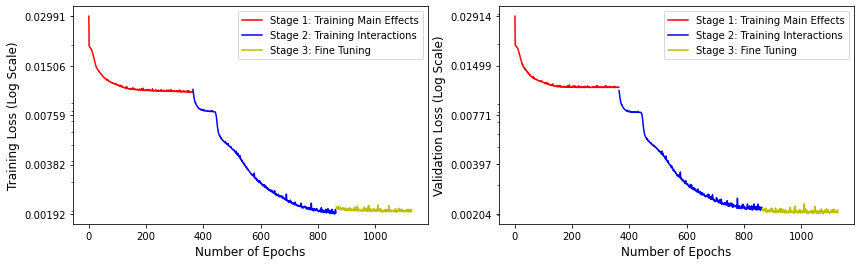

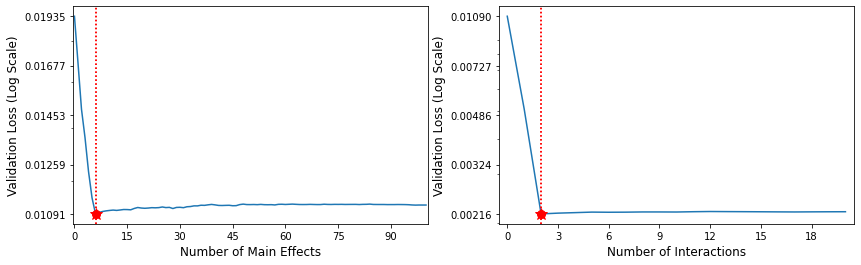

In [5]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

Global Visualization

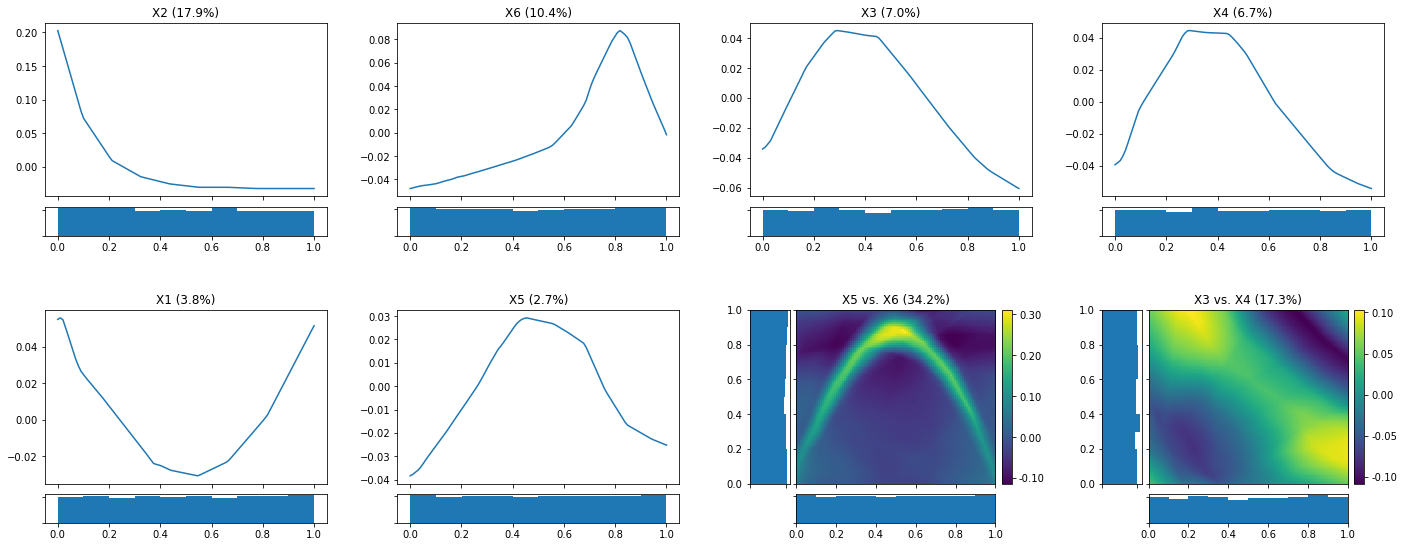

In [6]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=True, folder=simu_dir, name='s1_global')

Feature Importance

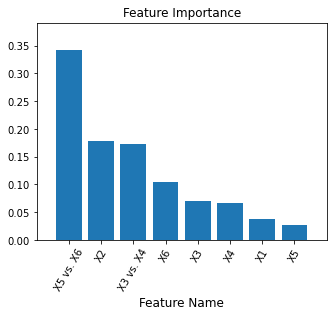

In [7]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [8]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

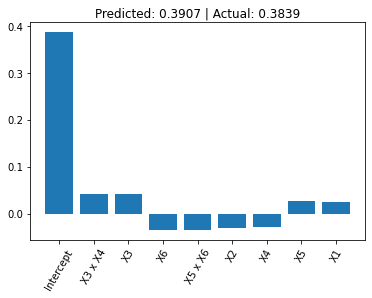

In [9]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

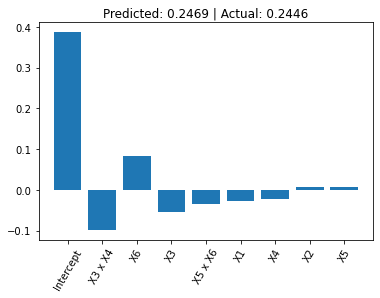

In [10]:
local_visualize(data_dict_local[1], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [11]:
model.save(folder="./", name="model_saved")

In [12]:
## The reloaded model should not be refit again
modelnew = GAMINet(meta_info={})
modelnew.load(folder="./", name="model_saved")